#Question 1


##Preprocessing, Visualization and finding most important features and train_test_split

In [460]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_sets/titanic.csv')
print(data.head())
print(data.info())

   PassengerId  ... Survived
0            1  ...        0
1            2  ...        1
2            3  ...        1
3            4  ...        1
4            5  ...        0

[5 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Name         891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   Ticket       891 non-null    object 
 6   Fare         891 non-null    float64
 7   Cabin        204 non-null    object 
 8   Embarked     889 non-null    object 
 9   Survived     891 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB
None


In [461]:
'''dropping cabin, passenger id, name and ticket column'''
data=data.drop("Cabin", axis=1)
data=data.drop("Name", axis=1)
data=data.drop("Ticket", axis=1)
data=data.drop("PassengerId", axis=1)


mean_age= data['Age'].mean()
data['Age'].fillna(mean_age, inplace=True)
data.dropna(inplace=True)
data.info()

view= data.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    object 
 2   Age       889 non-null    float64
 3   Fare      889 non-null    float64
 4   Embarked  889 non-null    object 
 5   Survived  889 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 48.6+ KB


In [462]:
embark_types=np.unique(data['Embarked'])
class_types= np.unique(data['Pclass'])
print(embark_types, class_types)

['C' 'Q' 'S'] [1 2 3]


In [463]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)


data_cat = data[["Embarked"]]
sex= data[["Sex"]]
class_= data[["Pclass"]]

data_embark=cat_encoder.fit_transform(data_cat)
data_sex=cat_encoder.fit_transform(sex)
data_class= data_sex=cat_encoder.fit_transform(class_)

# print(len(data_cat))

data['embarked_0']=data_embark[:, 0]
data['embarked_1']=data_embark[:, 1]
data['embarked_2']=data_embark[:, 2]
data['class_0']= data_class[:, 0]
data['class_1']= data_class[:, 1]
data['class_2']= data_class[:, 2]
data['sex_0']=data_sex[:, 0]
data['sex_1']=data_sex[:, 1]


# print(data.shape[0])

# data=data.drop("Embarked", axis=1)
# data=data.drop("Sex", axis=1)
# data=data.drop("Pclass", axis=1)

In [464]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

embark_ord_encoded = ordinal_encoder.fit_transform(data_cat)
sex_ord_encoded = ordinal_encoder.fit_transform(sex)

# print(data.shape[0])

data['Embarked_']= embark_ord_encoded
data['Sex_']= sex_ord_encoded

In [465]:
view= data.copy()
corr_matrix=view.corr()
print( corr_matrix['Survived'].sort_values(ascending=False))

Survived      1.000000
class_0       0.282368
sex_0         0.282368
Fare          0.255290
embarked_0    0.169966
class_1       0.095002
sex_1         0.095002
embarked_1    0.004536
Age          -0.074673
embarked_2   -0.151777
Embarked_    -0.169718
class_2      -0.320171
Pclass       -0.335549
Sex_         -0.541585
Name: Survived, dtype: float64


In [466]:
'''most useful columns'''

y=data['Survived']

cols= ['Sex_', 'Pclass', 'Fare']
drops=[ feature for feature in data.columns if feature not in cols]
data.drop(columns= drops, axis=1, inplace=True)

print(data.head())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, random_state=42, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

   Pclass     Fare  Sex_
0       3   7.2500   1.0
1       1  71.2833   0.0
2       3   7.9250   0.0
3       1  53.1000   0.0
4       3   8.0500   1.0
(711, 3) (178, 3) (711,) (178,)


##Identifying Best variant of NB

There are three variants of Naive Bayes we can choose for classification:- 1) Gaussian Naive Bayes - continuous features 2) Bernoulli Naive Bayes - binary features 3) Multinomial Naive Bayes - categorical features

Since  Fare are continuous features, it would be apropriate to use gaussian naive bayes over the other types since they would not be able to capture the variations in data as well.

##Implementing Gaussian Naive Bayes Model

In [467]:
def acc( test, pred):
  return np.sum(np.array(test)==np.array(pred))/np.array(pred).shape[0]

class Model():

  def __init__(self):
    self.feature=None
    self.mean_p=None
    self.mean_n=None
    self.std_p=None
    self.std_n=None
    self.prior_p=None
    self.prior_n=None

  def fit(self, x, y):
    p = x[y == 1]
    n = x[y == 0]
    self.prior_p = np.sum(p)/data.shape[0]
    self.prior_n = 1 -self.prior_p
      
    self.feature = []
    self.mean_p = []
    self.std_p = []
    self.mean_n = []
    self.std_n = []

    for f in x.columns:
      self.feature.append(f)
      self.mean_p.append(np.mean(p[f]))
      self.mean_n.append(np.mean(n[f]))
      self.std_p.append(np.std(p[f]))
      self.std_n.append(np.std(n[f]))


  def gauss(self, std, mean, x):
    val=((x-mean)/std)**2
    k=np.sqrt(2*np.pi)*std
    sol= np.exp(-0.5*val)
    # print(type(sol/k))
    return sol/k

  def predict(self, x):
    prediction=[]
    prob=[]
    residue=[]

    num, feats= x.shape
    for i in range(num):
      like_p=1
      like_n=1
      row= x.iloc[i, :]
      for feat_index in range(feats):
        like_p*= self.gauss( self.std_p[feat_index], self.mean_p[feat_index], row[feat_index]) ####<<<<<<<<<<<<<<<<<<<
        like_n*= self.gauss( self.std_n[feat_index], self.mean_n[feat_index], row[feat_index]) ####<<<<<<<<<<<<<<<
        # print(type(like_n))
      prediction.append(1 if like_p>like_n else 0)
      prob.append(like_p if like_p>like_n else like_n)
      residue.append(like_p if like_p<=like_n else like_n)
    
    prob= np.array(prob)/ (np.array(prob) + np.array(residue))
    sol= [np.array(prediction), prob]
    return sol
  


In [468]:
model=Model()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)[0]
y_pred_prob = model.predict(X_train)[0]
print('accuracy of model on train set: ',np.sum(y_pred == y_train)/y_pred.shape[0])
print(f'mean confidence for all predictions: ',np.mean(y_pred_prob))

accuracy of model on train set:  0.7721518987341772
mean confidence for all predictions:  0.3924050632911392


##Performing 5 fold CV

In [469]:

def cross(tree, X, y,folds ):
  x_chunks=np.array_split(X, folds)
  y_chunks=np.array_split(y, folds)
  val_scores=[]
  # print(len(y_chunks))
  for i in range(folds):
    X_test=x_chunks[i]
    y_test=y_chunks[i]

    x_train_splits=[]
    y_train_splits=[]

    for j in range(folds):
      if j!=i:
        x_train_splits.append(x_chunks[j])
        y_train_splits.append(y_chunks[j])

    X_train=pd.concat(x_train_splits)
    y_train=pd.concat(y_train_splits)    
    #folds ready in pd

    tree.fit(X_train, y_train)
    y_test= np.array(y_test)

    y_pred=tree.predict(X_test)[0]
    val_scores.append(acc(y_pred, y_test))

  return val_scores

scores_scratch= np.array(cross( model, X_train, y_train, 5))
print(scores_scratch)

[0.76223776 0.78169014 0.79577465 0.76056338 0.72535211]


##Visualization and summarization of model

In [470]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
model_nb= GaussianNB()
scores_inbuilt= np.array( cross_val_score( model_nb, X_train, y_train, cv=5))
print(scores_inbuilt)

[0.76923077 0.79577465 0.77464789 0.78169014 0.74647887]


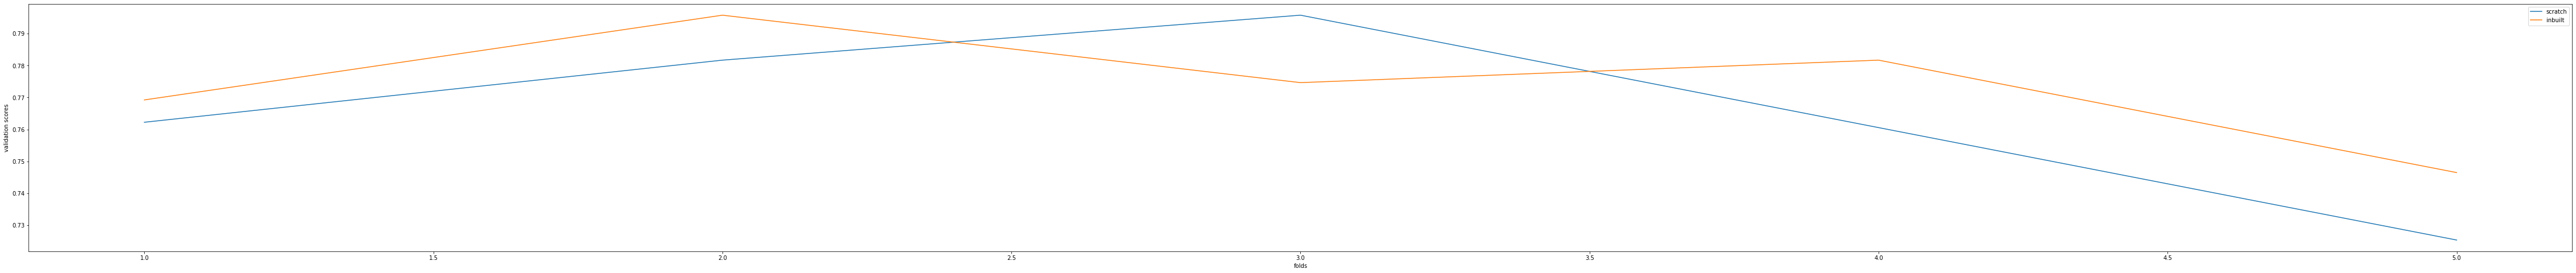

In [471]:
x= [1, 2, 3, 4, 5]
plt.plot(x, scores_scratch, label='scratch')
plt.plot(x, scores_inbuilt, label='inbuilt')
plt.xlabel('folds')
plt.legend()
plt.ylabel('validation scores')
plt.show()

In [472]:
print('mean validation score :', np.mean(scores_scratch))
print('variance in validation score: ', np.var(scores_scratch))

mean validation score : 0.7651236087855806
variance in validation score:  0.0005649663759179713


In [473]:
model= Model()
model.fit(X_train, y_train)
probas= model.predict(X_test)[1]
pred= model.predict(X_test)[0]
print('average confidence of top class: ',np.sum(probas)/probas.shape[0])
print('minimum confidence: ', np.min(probas))

average confidence of top class:  0.8586532602988465
minimum confidence:  0.5150276765932421


confidence of first 10 prediction:  [0.93317996 0.9991147  0.74549624 0.86612935 0.99030363 0.93292834
 0.86612935 0.9333811  0.9983197  0.99774948]
first 10 predictions:  [0 1 1 0 1 0 0 0 1 1]
actual classes:  [0 1 1 0 1 1 0 0 1 1]
accuracy:  0.9


Text(0, 0.5, 'confidence')

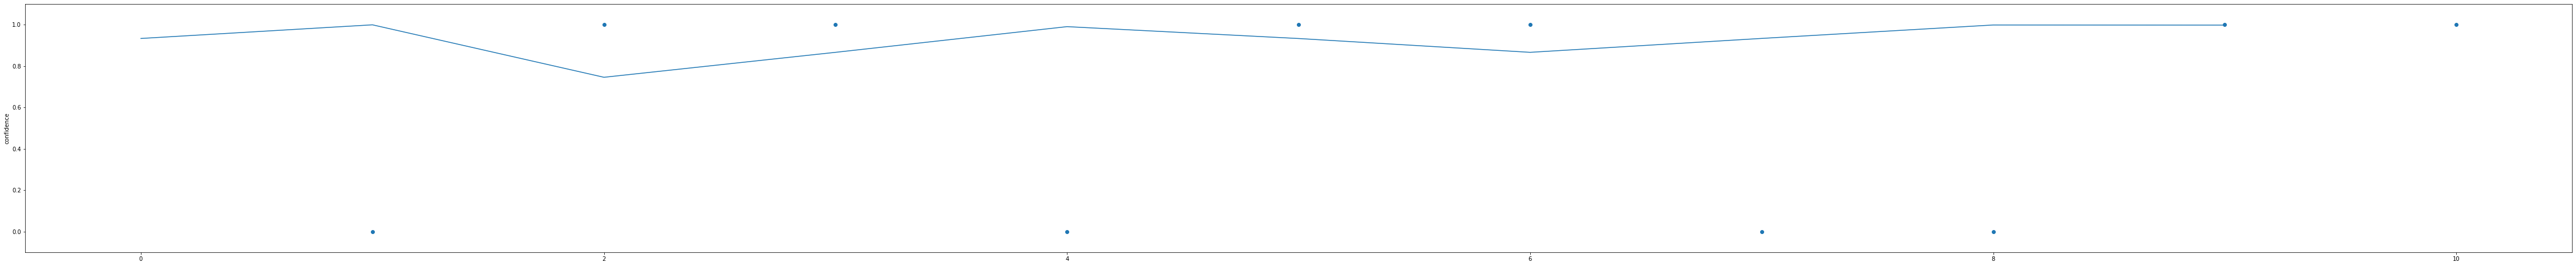

In [474]:
print('confidence of first 10 prediction: ',probas[:10])
print('first 10 predictions: ', pred[:10])
print('actual classes: ', np.array(y_test)[:10])
print( 'accuracy: ', acc(np.array(y_test)[:10], pred[:10]) )
y=acc(np.array(y_test)[:10], pred[:10])

ax = plt.gca()
plt.plot( probas[:10])
plt.scatter(np.arange(1, 11) ,np.array(y_test)[:10])
ax.set_ylim([-0.1, 1.1])
plt.ylabel('confidence')

##Comparison with inbuilt

mean validation scratch score : 0.7651236087855806
variance in scratch validation score:  0.0005649663759179713
average confidence of top class:  0.8586532602988465
accuracy:  0.7921348314606742

mean validation inbuilt score : 0.7735644637053087
variance in inbuilt validation score:  0.00026258056715993956
average confidence of top class:  0.5
accuracy:  0.7921348314606742


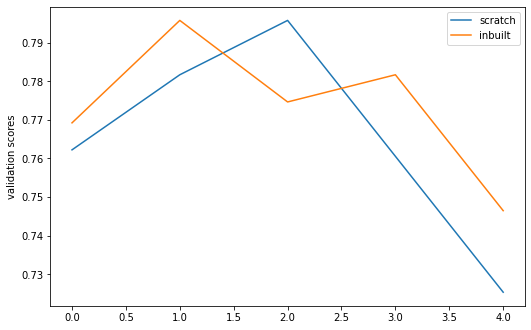

In [487]:
from sklearn.metrics import accuracy_score

model= Model()
model.fit(X_train, y_train)
probas= model.predict(X_test)[1]
pred= model.predict(X_test)[0]
scores_scratch= np.array(cross( model, X_train, y_train, 5))


print('mean validation scratch score :', np.mean(scores_scratch))
print('variance in scratch validation score: ', np.var(scores_scratch))
print('average confidence of top class: ',np.mean(probas))
print('accuracy: ', acc(pred, np.array(y_test)))
print()

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
model_nb= GaussianNB()
model_nb.fit(X_train, y_train)
pred_in= model_nb.predict(X_test)
probas_in= model_nb.predict_proba(X_test)
scores_inbuilt= np.array( cross_val_score( model_nb, X_train, y_train, cv=5))

print('mean validation inbuilt score :', np.mean(scores_inbuilt))
print('variance in inbuilt validation score: ', np.var(scores_inbuilt))
print('average confidence of top class: ',np.mean(probas_in))
print('accuracy: ', accuracy_score(y_test, pred_in ))

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
plt.plot(scores_scratch, label='scratch')
plt.plot(scores_inbuilt, label='inbuilt')
plt.legend()
plt.ylabel('validation scores')
plt.show()

##Comparison with DT

mean validation dt score : 0.8157588889983256
variance in dt validation score:  4.4896070520911876e-05
average confidence of top class:  0.5
accuracy of decision tree:  0.8033707865168539


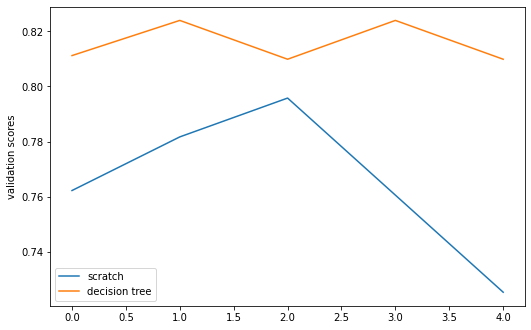

In [488]:
from sklearn.tree import DecisionTreeClassifier as DTC
clf=DTC()
scores_dt= cross_val_score(clf, X_train, y_train, cv=5)
print('mean validation dt score :', np.mean(scores_dt))
print('variance in dt validation score: ', np.var(scores_dt))
print('average confidence of top class: ',np.mean(probas_in))


clf.fit(X_train, y_train)
pred_dt= clf.predict(X_test)
print('accuracy of decision tree: ', accuracy_score(y_test, pred_dt))


fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
plt.plot(scores_scratch, label='scratch')
plt.plot(scores_dt, label='decision tree')
plt.legend()
plt.ylabel('validation scores')
plt.show()

#Question 2

##preprocessing and plotting distributions

In [477]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_sets/dataset_l4.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   15.26   209 non-null    float64
 1   14.84   209 non-null    float64
 2   0.871   209 non-null    float64
 3   5.763   209 non-null    float64
 4   3.312   209 non-null    float64
 5   2.221   209 non-null    float64
 6   5.22    209 non-null    float64
 7   1       209 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [478]:
'''
1. Area.
2. Perimeter.
3. Compactness
4. Length of kernel.
5. Width of kernel.
6. Asymmetry coefficient.
7. Length of kernel groove.
8. Class (1, 2, 3).'''

data_arr=np.array(data)
data2=pd.DataFrame()
data2['area']= data_arr[:,0]
data2['peri']= data_arr[:,1]
data2['comp']= data_arr[:,2]
data2['length']= data_arr[:,3]
data2['width']= data_arr[:,4]
data2['asymmetry']= data_arr[:,5]
data2['length_groove']= data_arr[:,6]
data2['class']= data_arr[:,7]

data= data2.copy()
print(data.head())
print(data.info())

    area   peri    comp  length  width  asymmetry  length_groove  class
0  14.88  14.57  0.8811   5.554  3.333      1.018          4.956    1.0
1  14.29  14.09  0.9050   5.291  3.337      2.699          4.825    1.0
2  13.84  13.94  0.8955   5.324  3.379      2.259          4.805    1.0
3  16.14  14.99  0.9034   5.658  3.562      1.355          5.175    1.0
4  14.38  14.21  0.8951   5.386  3.312      2.462          4.956    1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           209 non-null    float64
 1   peri           209 non-null    float64
 2   comp           209 non-null    float64
 3   length         209 non-null    float64
 4   width          209 non-null    float64
 5   asymmetry      209 non-null    float64
 6   length_groove  209 non-null    float64
 7   class          209 non-null    float64
dtypes: float64(8)
memor

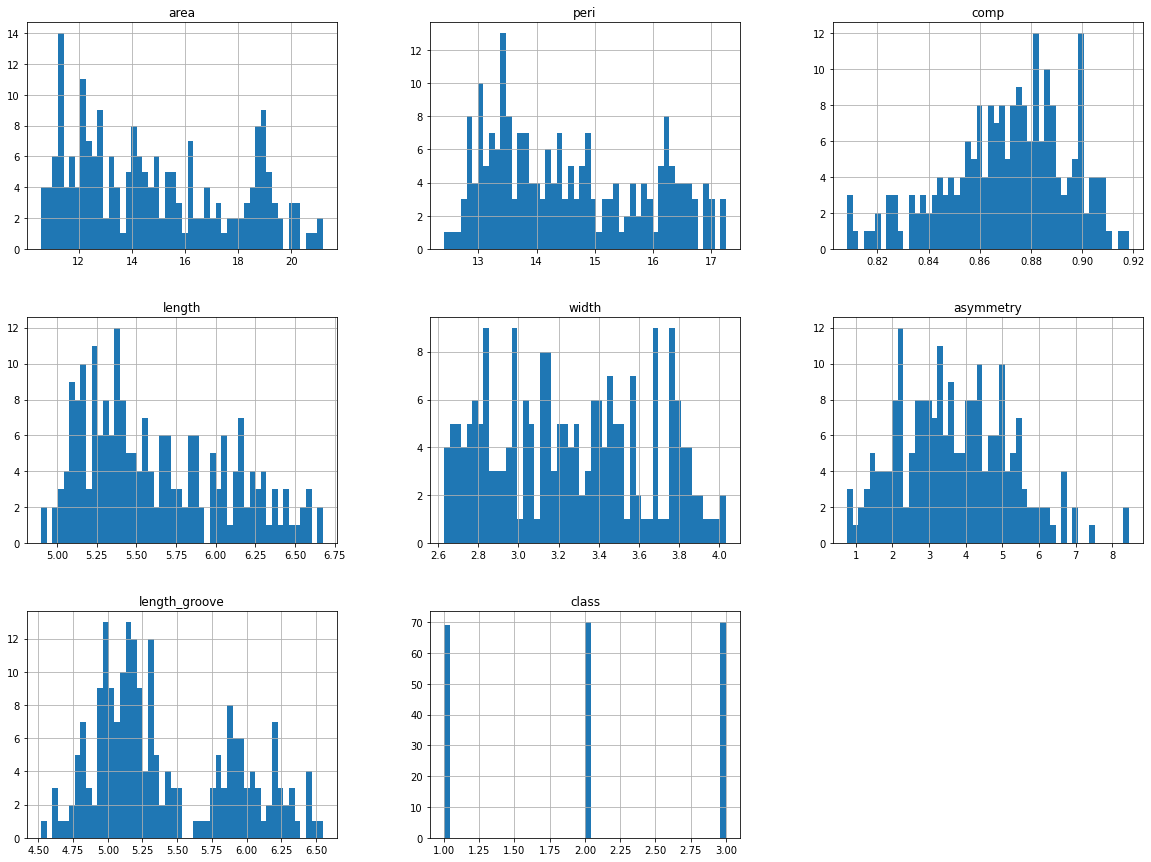

In [479]:
data.hist(bins=50, figsize=(20,15))
plt.show()

histplot for number of bins:  3


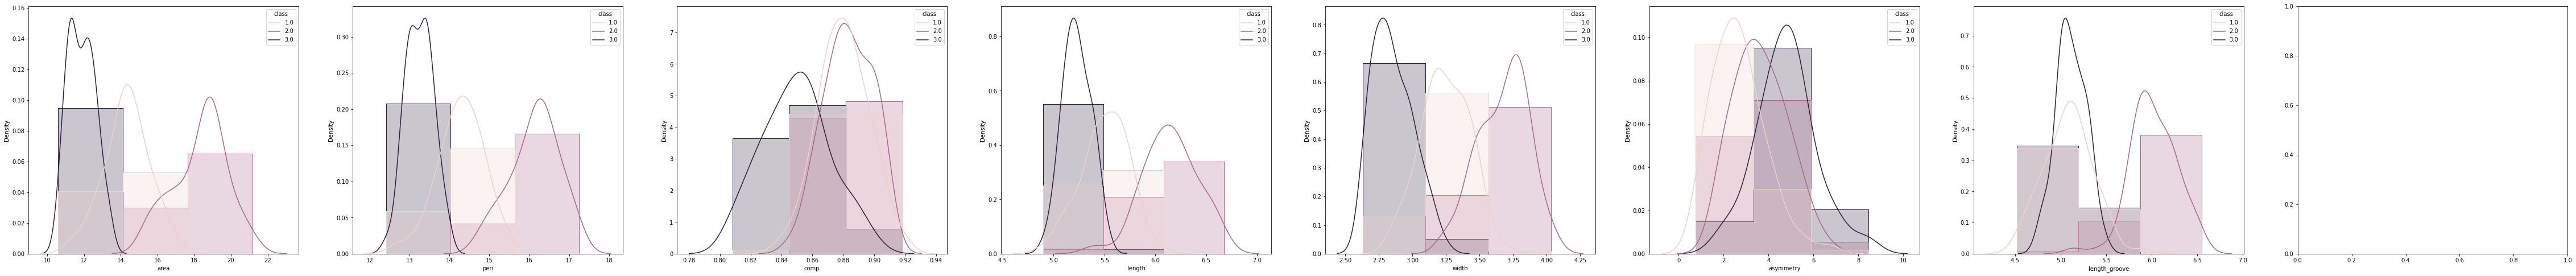

histplot for number of bins:  5


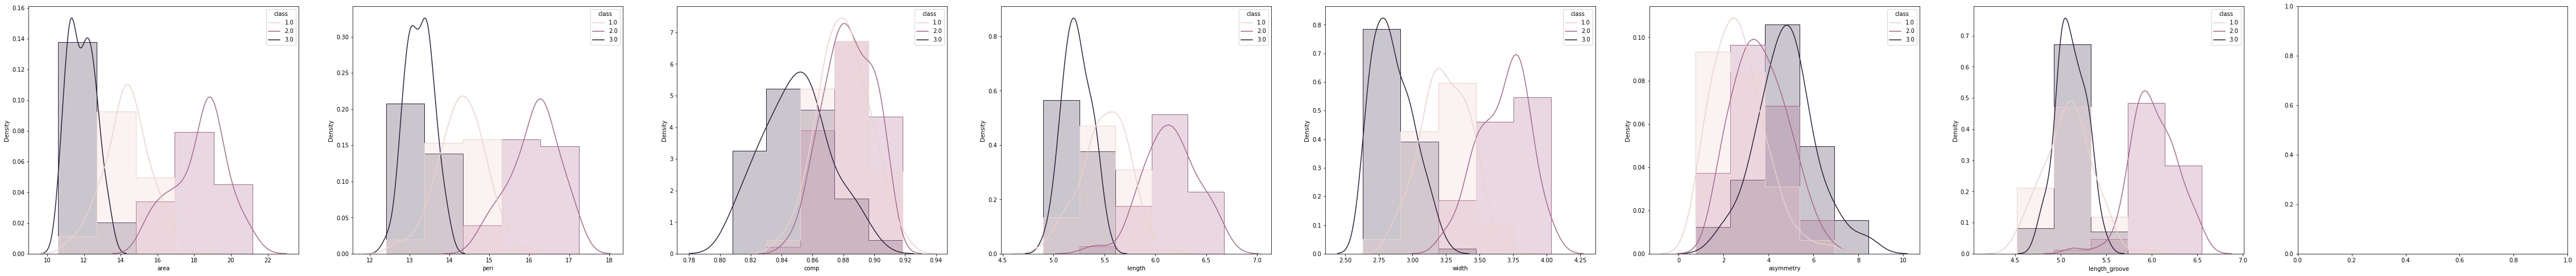

histplot for number of bins:  7


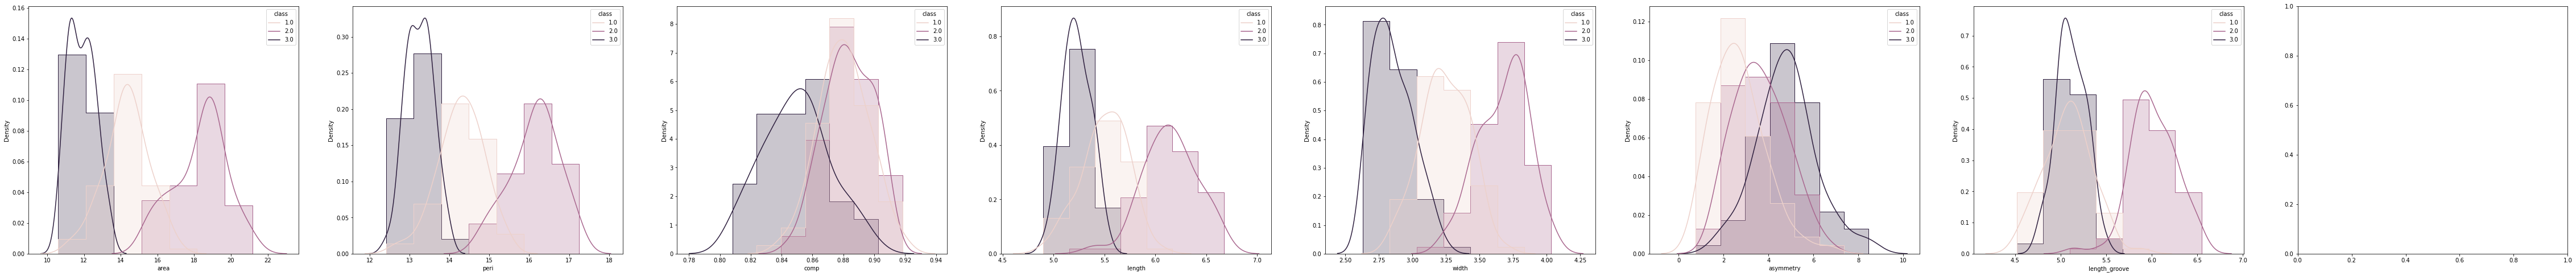

histplot for number of bins:  9


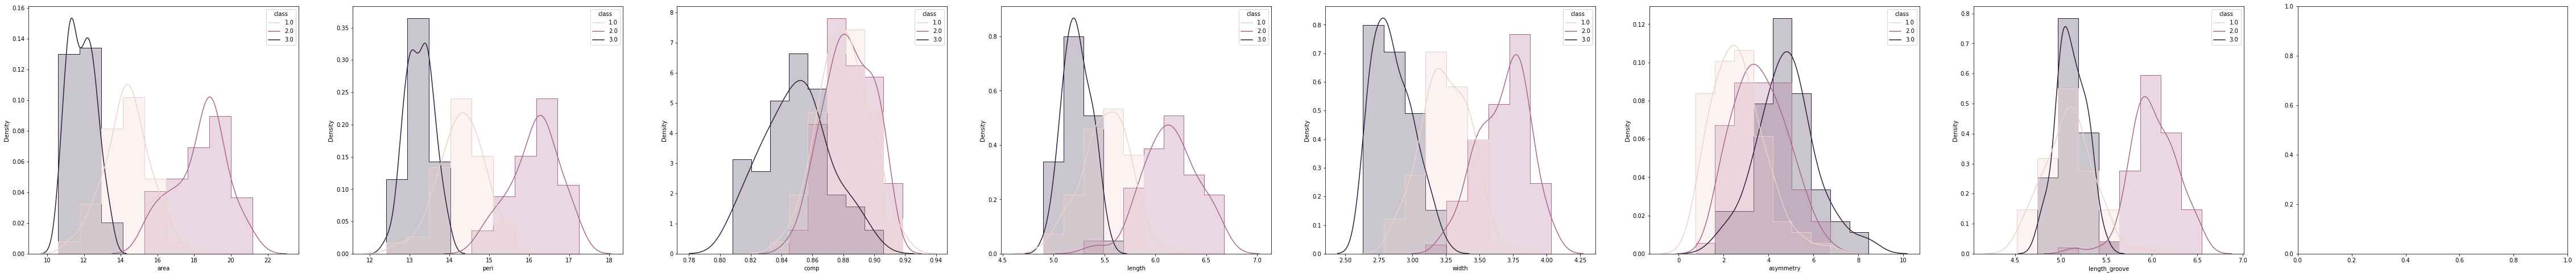

histplot for number of bins:  11


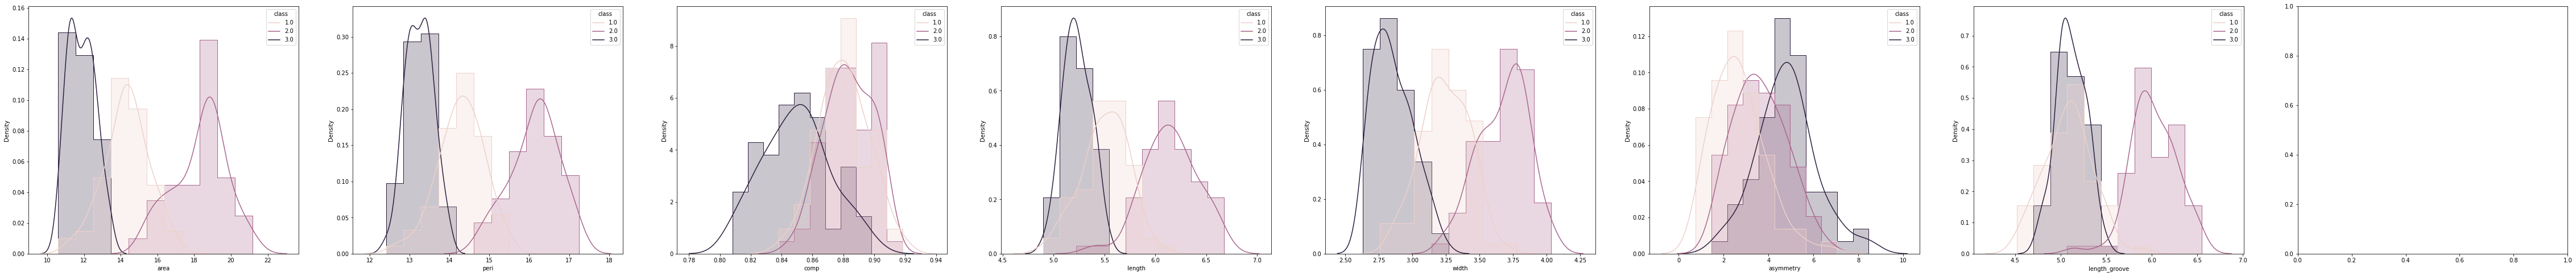

In [480]:

plt.rcParams["figure.figsize"] = (80, 8)
for bins in range(3,12,2):
  fig, axs = plt.subplots(nrows=1, ncols=data.shape[1])
  print(f"histplot for number of bins: ", bins)

  for index in range(len(data.columns)):
    if data.columns[index] != 'class': 
      slice = data.iloc[:, index:index+1]
      sns.histplot(data=data, x=data.columns[index], hue="class", element="step",  ax=axs[index], bins=bins, stat="density", )
      sns.kdeplot(data=data, x=data.columns[index], hue="class", ax=axs[index], )

  plt.show()

##Calculating Priors

In [481]:
y1=0
y2=0
y3=0
for i in data_arr[:, 7]:
  if i==1:
    y1+=1
  if i==2:
    y2+=1
  if i==3:
    y3+=1

prior=[ y1, y2, y3]
  
print('Prior of class 1: ', y1/len(data_arr[0:]))
print('Prior of class 2: ', y2/len(data_arr[0:]))
print('Prior of class 3: ', y3/len(data_arr[0:]))

Prior of class 1:  0.33014354066985646
Prior of class 2:  0.3349282296650718
Prior of class 3:  0.3349282296650718


##Discretizing into bins

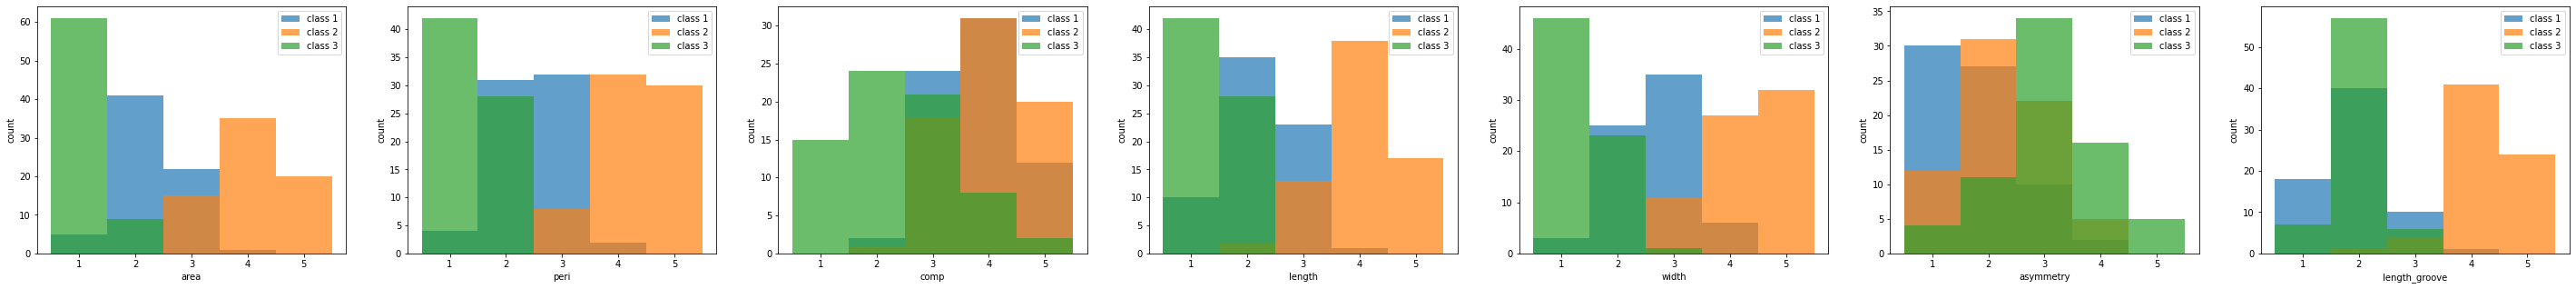

In [482]:

n_bins=5
plt.rcParams['figure.figsize'] = (50, 5)
fig, plot = plt.subplots(nrows=1, ncols=data.shape[1]-1)

for index in range(len(data.columns)):
  if data.columns[index] != 'class': 

    min = np.min(data[data.columns[index]])
    diff = (np.max(data[data.columns[index]]) - min)/n_bins

    strata=[]
    for i in range(n_bins-1):
      greater_than=data[data.columns[index]] >= min + diff*i
      lesser_than=data[data.columns[index]] < min + diff*(i+1)
      strata.append( greater_than*lesser_than*(i+1))

    greater_than=data[data.columns[index]] >= min + diff*(n_bins-1)
    strata.append( greater_than*n_bins)
    #print(strata)

    new_feature = np.sum(np.array(strata), axis=0)

    new_feature = ((np.array([new_feature, data['class']])).T)
    new_feature = pd.DataFrame(new_feature, columns=[data.columns[index], 'class'])
    #print(new_feature)
    data[data.columns[index]] = new_feature[data.columns[index]]
    

    x1 = new_feature[data.columns[index]][new_feature['class']==1]
    x2 = new_feature[data.columns[index]][new_feature['class']==2]
    x3 = new_feature[data.columns[index]][new_feature['class']==3]
    line = np.linspace(0.5, n_bins+0.5, num=n_bins+1)
    plot[index].hist(x1, line, alpha=0.7, label="class 1", linewidth="0", edgecolor="blue")
    plot[index].hist(x2, line, alpha=0.7, label="class 2", linewidth="0", edgecolor="orange")
    plot[index].hist(x3, line, alpha=0.7, label="class 3", linewidth="0", edgecolor="green")


    plot[index].legend()
    plot[index].set_ylabel('count')

    plot[index].set_xlabel(f"{data.columns[index]}")

plt.show()


##Calculating Likelihood and plotting

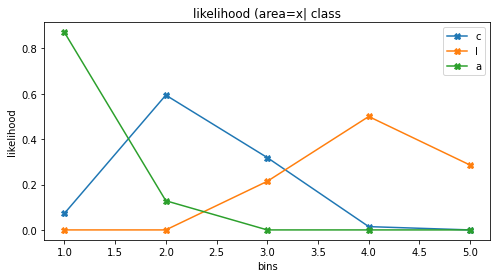

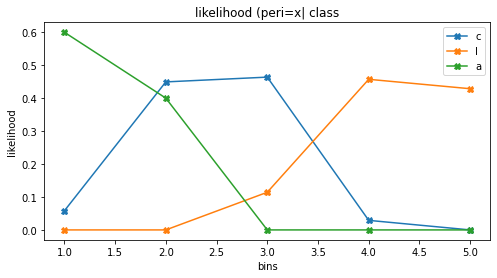

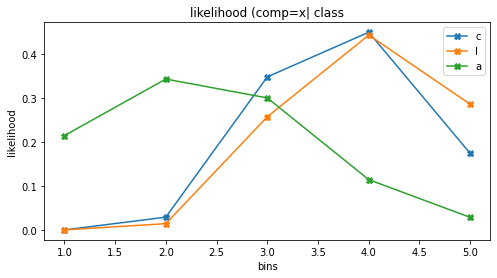

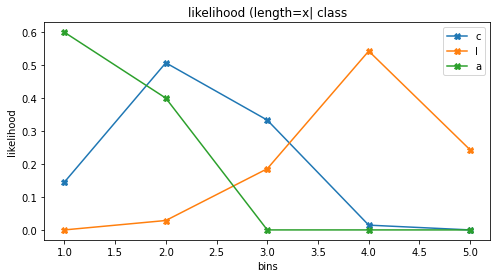

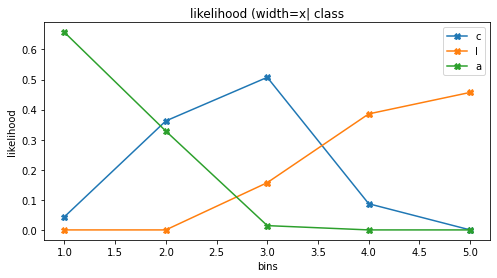

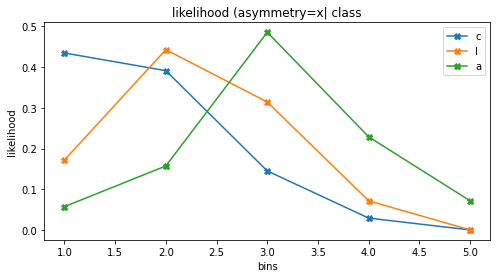

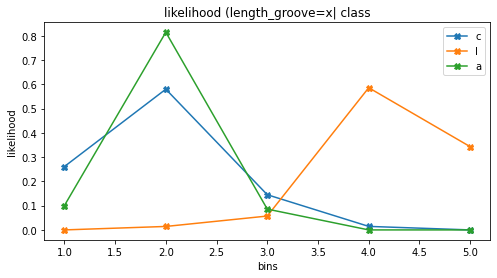

In [483]:

plt.rcParams['figure.figsize'] = (8, 4)
for feature in data.columns:
  if feature=='class':
    continue
  x=data[feature]
  pros=[]
  for cls in range(1,4):
    for b in range(1,6):
      like=  np.sum((data[feature]==b)*(data['class']==cls))/np.sum(data['class']==cls)
      pros.append(like)
    plt.plot(range(1,6), pros, marker='X', label=f"class: {cls}")
    pros=[]
    plt.xlabel('bins')
    plt.ylabel('likelihood')
    plt.legend(f"class: {cls}")
    plt.title(f"likelihood ({feature}=x| class")
  plt.show()

##Calculating and plotting posteriors

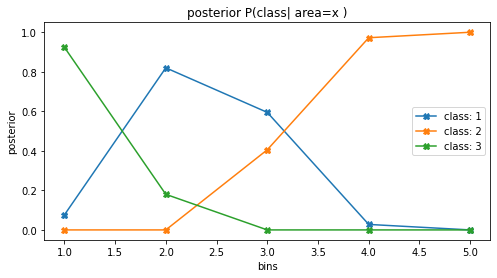

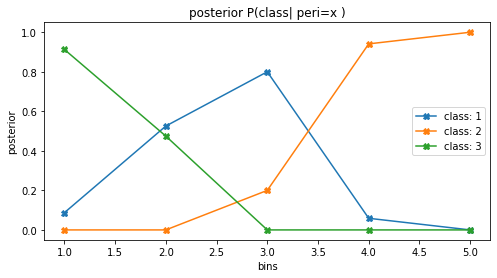

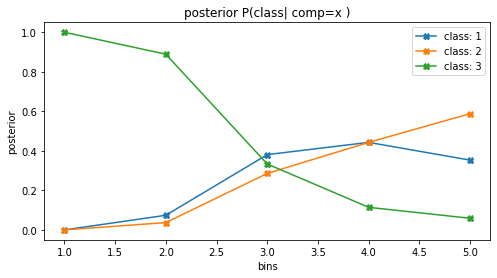

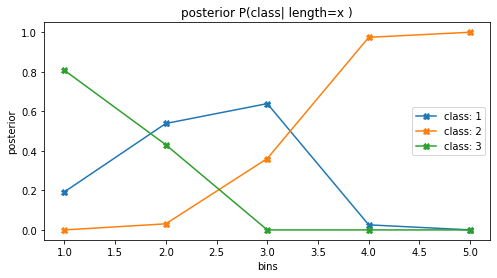

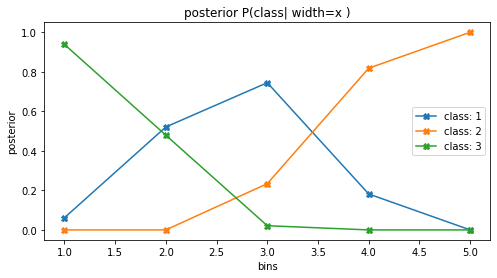

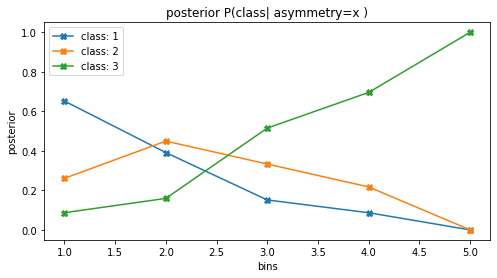

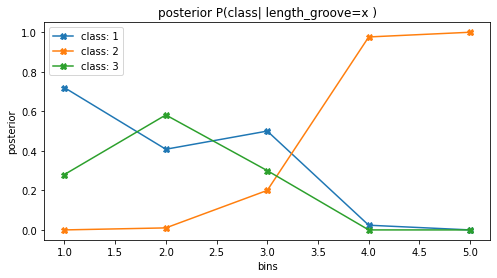

In [490]:

for feature in data.columns:
  if feature=='class':
    continue
  y= data['class']
  x= data[feature]
  pros={} ## << []
  for cls in range(1, 4):
    pros[cls]=[]
    for b in range(1,6):
      prior_ = prior[cls-1]
      like= np.sum((x==b)*(y==cls))/np.sum(y==cls)
      evid= np.sum(x==b)/data.shape[0]
      posterior= like*prior_/evid
      pros[cls].append(posterior)

  l=pros[1]+pros[2]+pros[3]
  mx=max(l)
  pros[1]=np.array(pros[1])/mx
  pros[2]=np.array(pros[2])/mx
  pros[3]=np.array(pros[3])/mx
  plt.plot(range(1,6), pros[1], marker='X', label=f"class: 1")
  plt.plot(range(1,6), pros[2], marker='X', label=f"class: 2")
  plt.plot(range(1,6), pros[3], marker='X', label=f"class: 3")
  pros={}
  plt.xlabel('bins')
  plt.ylabel('posterior')
  plt.title(f"posterior P(class| {feature}=x )")
  plt.legend()
  plt.show()   